In [0]:
import pickle
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import io
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split(" "))
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data


In [0]:
#embeddings_vectors = load_vectors("twitter.vec")

# Dataset

In [0]:
col_names=["target","id","datetime","query","user","text"]

In [0]:
clean_re = re.compile('\W+')
url_re = re.compile("https?://[^\s]+")
hashtag_re = re.compile("#(\w+)")
mention_re = re.compile("@(\w+)")
def preprocessing(text):
    """
    Realiza el preprocesado de un determinado texto:
    1- sustituye las urls por la palabra <url>
    2- sustituye los hashtags por la palabra <hashtag>
    3- sustituye las menciones por la palabra <mencion>
    4- sustituye los numeros por la palabra <numero>
    """
    text_clean = url_re.sub("<url>",text)
    text_clean = hashtag_re.sub("<hashtag>", text_clean)
    text_clean = mention_re.sub("<mencion>", text_clean)
    text_clean =re.sub("\d+", "<numero>", text_clean)
    #text_clean = clean_re.sub(" ",text_clean).lower()
    text_clean = text_clean.lower()
    #text_clean = Stemming(text_clean)
    
    return text_clean

In [0]:
dataframe =  pd.read_csv("training.1600000.processed.noemoticon.csv",encoding = "ISO-8859-1",names=col_names)

In [0]:
dataframe.target = dataframe.target.map({0:0,4:1})
dataframe.text = dataframe.text.apply(preprocessing)

In [0]:
dataframe

,target,id,datetime,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"<mencion> <url> - awww, that's a bummer. you ..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,<mencion> i dived many times for the ball. man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"<mencion> no, it's not behaving at all. i'm ma..."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up. having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb.com - very cool to hear old walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover? ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy <numero>th birthday to my boo of alll ti...


In [0]:
dataframe.groupby("target").count()

,id,datetime,query,user,text
target,,,,,
0,800000,800000,800000,800000,800000
1,800000,800000,800000,800000,800000


In [0]:
train, test = train_test_split(dataframe, test_size=0.2,random_state=10)

In [0]:
train.groupby("target").count()

,id,datetime,query,user,text
target,,,,,
0,640165,640165,640165,640165,640165
1,639835,639835,639835,639835,639835


In [0]:
test.groupby("target").count()

,id,datetime,query,user,text
target,,,,,
0,159835,159835,159835,159835,159835
1,160165,160165,160165,160165,160165


In [0]:
num_clases = 2

# Bag of words + NN

In [0]:
maxfeature = 60000
vectorizer = TfidfVectorizer(lowercase=True,max_features=maxfeature,stop_words="english",ngram_range=(1,3))
trainBOW = vectorizer.fit_transform(train.text)
testBOW = vectorizer.transform(test.text)
y_train = to_categorical(train.target,num_clases)
y_test = to_categorical(test.target,num_clases)

In [0]:
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
model = Sequential()
model.add(Dense(256,input_shape=(maxfeature,)))
model.add(BN())
model.add(GN(0.2))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(BN())
model.add(GN(0.2))
model.add(Activation('relu'))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               15360256  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 256)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 128)              

In [0]:
sgd=SGD(lr=0.1, decay=0.0, momentum=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [0]:
history = model.fit(trainBOW, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(testBOW, y_test),callbacCroquetas1997
                    ks=callbacks_list)

Train on 1280000 samples, validate on 320000 samples
Epoch 1/10
1280000/1280000 [==============================] - 696s 543us/step - loss: 0.4728 - accuracy: 0.7728 - val_loss: 0.4537 - val_accuracy: 0.7852

Epoch 00001: val_accuracy improved from -inf to 0.78517, saving model to weights-improvement-01-0.79.hdf5
Epoch 2/10
1280000/1280000 [==============================] - 695s 543us/step - loss: 0.4287 - accuracy: 0.7998 - val_loss: 0.4505 - val_accuracy: 0.7863

Epoch 00002: val_accuracy improved from 0.78517 to 0.78632, saving model to weights-improvement-02-0.79.hdf5
Epoch 3/10
1280000/1280000 [==============================] - 691s 540us/step - loss: 0.4005 - accuracy: 0.8156 - val_loss: 0.4574 - val_accuracy: 0.7852

Epoch 00003: val_accuracy did not improve from 0.78632
Epoch 4/10
1280000/1280000 [==============================] - 695s 543us/step - loss: 0.3647 - accuracy: 0.8340 - val_loss: 0.4819 - val_accuracy: 0.7811

Epoch 00004: val_accuracy did not improve from 0.78632
Ep

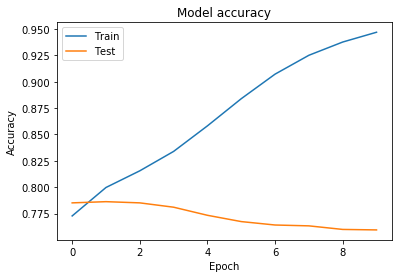

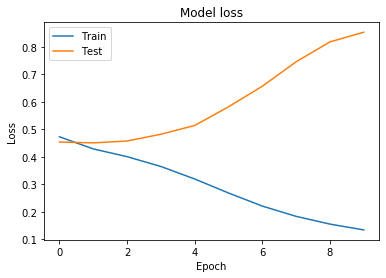

In [0]:
# Evolución del accuracy de train y test
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Evolución del la funcion de perdida en train y test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# LSTM 

In [0]:
#Habilitamos un tokenizer
tok = Tokenizer(char_level=False,oov_token="oov",lower=True)

In [0]:
#creamos los indices para el train
tok.fit_on_texts(list(train.text))

In [0]:
#Transformamos los tweets en secuencias de numeros
textIntSequenceTrain = tok.texts_to_sequences(list(train.text))
textIntSequenceTest = tok.texts_to_sequences(list(test.text))

In [0]:
maxLen = max([len(textSeq) for textSeq in textIntSequenceTrain])
maxLen

118

In [0]:
x_train = sequence.pad_sequences(textIntSequenceTrain,maxLen)
x_test = sequence.pad_sequences(textIntSequenceTest,maxLen)
y_train = to_categorical(train.target,num_clases)
y_test = to_categorical(test.target,num_clases)

In [0]:
word_index = tok.word_index
len(word_index)

255821

In [0]:
#model 
model = Sequential()
model.add(Embedding(len(word_index)+1,100, input_length=maxLen))
model.add(LSTM(128, dropout=0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 118, 100)          25582200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 25,699,706
Trainable params: 25,699,706
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
          batch_size=512,
          epochs=10,
          validation_data=(x_test, y_test))

C:\Users\Marcos Esteve\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1280000 samples, validate on 320000 samples
Epoch 1/10
1280000/1280000 [==============================] - 349s 273us/step - loss: 0.4254 - accuracy: 0.8028 - val_loss: 0.3925 - val_accuracy: 0.8202
Epoch 2/10
1280000/1280000 [==============================] - 349s 273us/step - loss: 0.3709 - accuracy: 0.8340 - val_loss: 0.3843 - val_accuracy: 0.8258
Epoch 3/10
1280000/1280000 [==============================] - 348s 272us/step - loss: 0.3444 - accuracy: 0.8480 - val_loss: 0.3873 - val_accuracy: 0.8257
Epoch 4/10
1280000/1280000 [==============================] - 349s 273us/step - loss: 0.3233 - accuracy: 0.8589 - val_loss: 0.3955 - val_accuracy: 0.8242
Epoch 5/10
1280000/1280000 [==============================] - 349s 273us/step - loss: 0.3050 - accuracy: 0.8679 - val_loss: 0.4052 - val_accuracy: 0.8233
Epoch 6/10
1280000/1280000 [==============================] - 348s 272us/step - loss: 0.2879 - accuracy: 0.8763 - val_loss: 0.4140 - val_accuracy: 0.8232
Epoch 7/10
1280000/1280

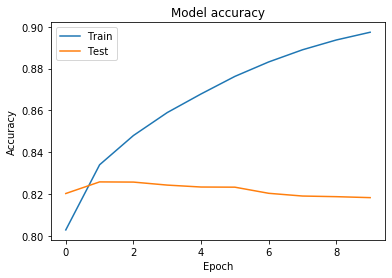

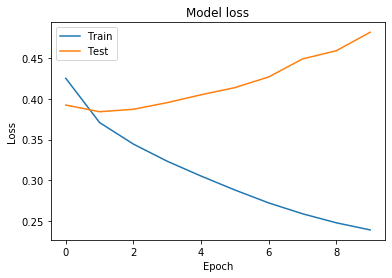

In [0]:
# Evolución del accuracy de train y test
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Evolución del la funcion de perdida en train y test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()